# Passenger Satisfaction Classification Analyzing using Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.losses import BinaryCrossentropy
from keras.losses import MeanSquaredError
from keras.losses import SparseCategoricalCrossentropy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import itertools
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test])
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Preprocessing

In [3]:
data.dropna(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129487 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129487 non-null  int64  
 1   id                                 129487 non-null  int64  
 2   Gender                             129487 non-null  object 
 3   Customer Type                      129487 non-null  object 
 4   Age                                129487 non-null  int64  
 5   Type of Travel                     129487 non-null  object 
 6   Class                              129487 non-null  object 
 7   Flight Distance                    129487 non-null  int64  
 8   Inflight wifi service              129487 non-null  int64  
 9   Departure/Arrival time convenient  129487 non-null  int64  
 10  Ease of Online booking             129487 non-null  int64  
 11  Gate location                      129487 non

In [5]:
data.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

### Label Encoding

#### Satisfied: 1
#### Dissatisfied: 0

In [6]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        output = X.copy()
        for col, le in self.label_encoders.items():
            output[col] = le.transform(output[col])
        return output

In [7]:
# Instantiate MultiColumnLabelEncoder with desired columns
mcle = MultiColumnLabelEncoder(columns=['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'])

# Fit and transform dataset using MultiColumnLabelEncoder
data_encoded = mcle.fit_transform(data)


In [8]:
X = data_encoded.iloc[:,2:-1].values
y = data_encoded.iloc[:,-1].values
X

array([[ 1,  0,  6, ...,  5, 25, 18],
       [ 1,  1, 18, ...,  1,  1,  6],
       [ 0,  0, 19, ...,  5,  0,  0],
       ...,
       [ 0,  0, 10, ...,  2,  0,  0],
       [ 1,  0,  7, ...,  4,  0,  0],
       [ 0,  0, 35, ...,  1,  0,  0]], dtype=int64)

### Scaling the data

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 1.01493148, -0.47349456, -1.74842493, ...,  1.30462366,
         0.29099067,  0.08234098],
       [ 1.01493148,  2.11195667, -0.954528  , ..., -1.74039966,
        -0.37571892, -0.24496118],
       [-0.98528819, -0.47349456, -0.88836993, ...,  1.30462366,
        -0.40349848, -0.40861226],
       ...,
       [-0.98528819, -0.47349456, -1.48379262, ..., -0.97914383,
        -0.40349848, -0.40861226],
       [ 1.01493148, -0.47349456, -1.68226685, ...,  0.54336783,
        -0.40349848, -0.40861226],
       [-0.98528819, -0.47349456,  0.17015931, ..., -1.74039966,
        -0.40349848, -0.40861226]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Getting the most important features

In [11]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 11 (0.233542)
2. feature 4 (0.168714)
3. feature 6 (0.123594)
4. feature 3 (0.112307)
5. feature 13 (0.089181)
6. feature 15 (0.048488)
7. feature 12 (0.043061)
8. feature 8 (0.028782)
9. feature 1 (0.026897)
10. feature 14 (0.022511)
11. feature 19 (0.021375)
12. feature 5 (0.016379)
13. feature 18 (0.014775)
14. feature 16 (0.013554)
15. feature 17 (0.011932)
16. feature 2 (0.009253)
17. feature 7 (0.005523)
18. feature 10 (0.004869)
19. feature 9 (0.003246)
20. feature 21 (0.000971)
21. feature 0 (0.000682)
22. feature 20 (0.000366)


In [12]:
columns = ['Unnamed: 0', 'id', 'Gender', 'Age', 'Flight Distance', 'Departure/Arrival time convenient',
           'Gate location', 'Food and drink', 'Baggage handling', 'Checkin service',
           'Inflight service', 'Cleanliness', 'Departure Delay in Minutes',
           'Arrival Delay in Minutes']
data_encoded.drop(columns=columns, inplace=True, axis=1)
data_encoded.head()

,Customer Type,Type of Travel,Class,Inflight wifi service,Ease of Online booking,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,satisfaction
0,0,1,2,3,3,3,5,5,4,3,0
1,1,0,0,3,3,3,1,1,1,5,0
2,0,0,0,2,2,5,5,5,4,3,1
3,0,0,0,2,5,2,2,2,2,5,0
4,0,0,0,3,3,5,5,3,3,4,1


In [13]:
X = data_encoded.iloc[:,2:-1].values
y = data_encoded.iloc[:,-1].values
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Making a Deep Learning model

In [14]:
model = Sequential([
    Dense(units=25, activation='relu'),
    Dense(units=15, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss=BinaryCrossentropy())

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
3238/3238 [==============================] - 3s 744us/step - loss: 0.2792
Epoch 2/100
3238/3238 [==============================] - 2s 745us/step - loss: 0.2191
Epoch 3/100
3238/3238 [==============================] - 2s 727us/step - loss: 0.2011
Epoch 4/100
3238/3238 [==============================] - 2s 741us/step - loss: 0.1925
Epoch 5/100
3238/3238 [==============================] - 2s 713us/step - loss: 0.1891
Epoch 6/100
3238/3238 [==============================] - 2s 721us/step - loss: 0.1866
Epoch 7/100
3238/3238 [==============================] - 2s 747us/step - loss: 0.1852
Epoch 8/100
3238/3238 [==============================] - 2s 719us/step - loss: 0.1838
Epoch 9/100
3238/3238 [==============================] - 3s 780us/step - loss: 0.1824
Epoch 10/100
3238/3238 [==============================] - 2s 716us/step - loss: 0.1809
Epoch 11/100
3238/3238 [==============================] - 2s 722us/step - loss: 0.1796
Epoch 12/100
3238/3238 [============================

In [15]:
yhat = model.predict(X_test)
yhat

810/810 [==============================] - 1s 595us/step


array([[0.99992615],
       [0.09026292],
       [0.00398739],
       ...,
       [0.99973977],
       [0.9999433 ],
       [0.04385803]], dtype=float32)

In [16]:
def my_func(x):
    # Define your function here
    if x > 0.5:
        return 1
    else:
        return 0
    
my_vectorized_func = np.vectorize(my_func)
result = my_vectorized_func(yhat)

result = result.flatten()
yhat = result

In [18]:
print('test accuracy is:', metrics.accuracy_score(y_test, yhat))

test accuracy is: 0.9268669395320102


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 9980  1250]
 [  644 14024]]


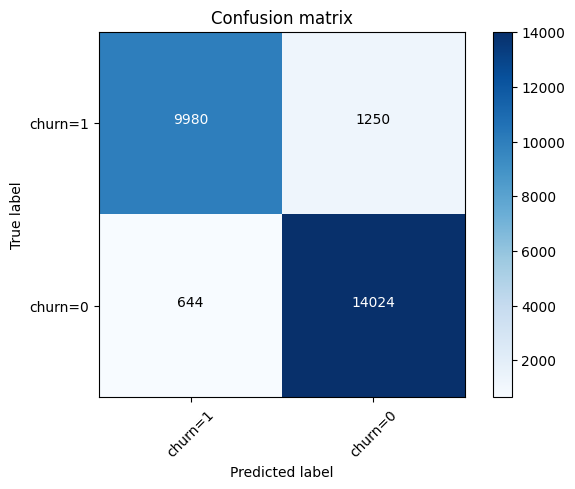

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [21]:
print (classification_report(y_test, yhat))
#satisfied: 1
#dissatisfied: 0

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     14668
           1       0.94      0.89      0.91     11230

    accuracy                           0.93     25898
   macro avg       0.93      0.92      0.93     25898
weighted avg       0.93      0.93      0.93     25898

